## The problem

Assume there is a website that has two layouts. During the test, 4% of visitors to layout A convert (i.e., buy something, sign up for the mailing list, whatever), and 5% to layout B convert. When asking the question of which one is better, one could rush to say B. However, the test doesn't say much about the sample that has been used, thus, we don't have a 100% confidnce that choice B is better. in this notebook, we will use a basic implementation of Bayesian inference to build up an algorithm that can return a confidence number for our choice of layout.

In [1]:
# import packages
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Set variables of the given problem

n_visitors_a = 100  # number of visitors shown layout A
n_conv_a = 4        # number of vistors shown layout A who converted

n_visitors_b = 40
n_conv_b = 2

In [3]:
print('Conversion rate for layout A is {:.0f} %,\nConversion rate for layout B is {:.0f} %'.format((n_conv_a/n_visitors_a)*100,(n_conv_b/n_visitors_b)*100))

Conversion rate for layout A is 4 %,
Conversion rate for layout B is 5 %


In [4]:
# Return number of vistors who convert, given conversion fraction p.
def simulate_conversion(p, n_visitors):
    outcomes = (random.random() < p for i in range(n_visitors))
    return sum(outcomes)

In [5]:
simulate_conversion(0.1, 100), simulate_conversion(0.1, 100), simulate_conversion(0.1, 100)

(12, 9, 8)

In [6]:
# Yield random numbers in interval (0, 1). We assume that layout has a uniform distribution
def uniform_prior_sampler():
    while True:
        yield random.random()

In [7]:
# a function that turns prior to a posterior
def posterior_sampler(data, prior_sampler, simulate):
    '''Yield samples from the posterior by Approximate Bayesian Computation.'''
    for p in prior_sampler:
        if simulate(p) == data:
            yield p

In [8]:
# a function that returns n number of samples from a distribution
def take(n, iterable):
    return list(itertools.islice(iterable, n))

In [9]:
take(3, uniform_prior_sampler())

[0.5083734789685357, 0.5123260585202584, 0.05303509939630269]

## Posterior of A

In [10]:
posterior_a_sampler = posterior_sampler(
    data=n_conv_a,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, n_visitors_a)
)

In [11]:
take(3, posterior_a_sampler)

[0.037610639233099485, 0.02139196466737825, 0.05182150048345546]

In [12]:
# select 1k samples
a_samples = take(10000, posterior_a_sampler)

(0, 0.245)

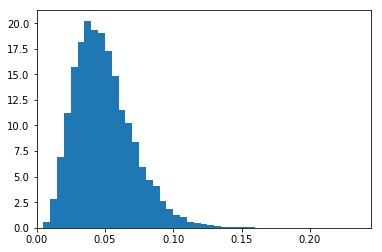

In [13]:
# plot histogram of 1k samples from posterior of layout a
abbins = [i/200.0 for i in range(50)]          # 50 bins between 0 and 0.25
plt.hist(a_samples, bins=abbins, normed=True)  # normed=True gives a probability density function
plt.xlim(0, max(abbins))                       

use the above posterior distribution to answer the following question: how likely it is that layout A's conversion fraction is greater than 10% ?

In [14]:
print("The likelyhood that layout A's conversion fraction is greater than 10% is : {:.0f}%".format(sum(a > 0.1 for a in a_samples)/len(a_samples)*100))


The likelyhood that layout A's conversion fraction is greater than 10% is : 2%


in other words we are 98% certain that layout A's conversion fraction is less than 10%

## Next, add the posterior of B

In [15]:
# we assume that layout B has a normal distribution with mean 0.06 and std of 0.02
def normal_prior_sampler(mu=0.06, sigma=0.02):
    '''Yield stream of samples from N(mu, sigma) in interval (0, 1).'''
    while True:
        x = random.normalvariate(mu, sigma)
        if 0 <= x <= 1:
            yield x

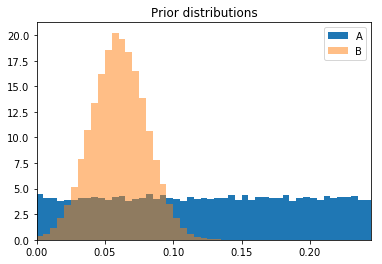

In [16]:
#plot both prior distributions
plt.hist(take(100000, uniform_prior_sampler()), bins=abbins, label='A', normed=True)
plt.hist(take(100000, normal_prior_sampler()), bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Prior distributions')
plt.xlim(0, max(abbins))
plt.legend();

In [17]:
# Calculate the posterio of B
posterior_b_sampler = posterior_sampler(
    data=n_conv_b,
    prior_sampler=normal_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, n_visitors_b)
)
b_samples = take(10000, posterior_b_sampler)

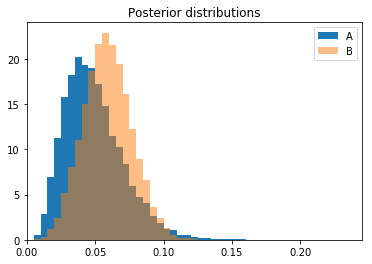

In [18]:
# plot posterior distributions for A and B
plt.hist(a_samples, bins=abbins, label='A', normed=True)
plt.hist(b_samples, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Posterior distributions')
plt.xlim(0, max(abbins));
plt.legend();

In [24]:
print("The likelyhood that layout B is better than layout A is : {:.2f}%".format(sum(b > a for a, b in zip(a_samples, b_samples))/len(a_samples)*100))

The likelyhood that layout B is better than layout A is : 65.89%


## References

- [probabilistic programming from scratch](https://www.oreilly.com/learning/probabilistic-programming-from-scratch)
- [Probabilistic Programming and Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
